In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import wandb

In [4]:
from sine_data_generator import SineDataGenerator
from models.decoder import Decoder
from models.utils import ReluNet, make_leave_one_out
from models.encoder import DeterministicIOPairSetEncoder
from models.lpn import DeterministicLPN

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_metaiter = 30_001
n_samples_per_task = 20
batch_size = 25
d_latent = 4

In [8]:

# Create encoder
encoder = DeterministicIOPairSetEncoder(
    phi=ReluNet(2, 16, 32),
    rho_0=ReluNet(32, 16, 16),
    rho_1=ReluNet(16, 8, d_latent)
)

# Create decoder
decoder = Decoder(
    d_input=1, 
    d_latent=d_latent, 
    ds_hidden=[16, 16, 16], 
    d_output=1
)

# Create the model
lpn = DeterministicLPN(
    d_input=1,
    d_output=1,
    d_latent=d_latent,
    encoder=encoder,
    decoder=decoder
).to(device)

# Create data generator for training
data_gen = SineDataGenerator(n_samples_per_task, batch_size)

In [20]:
# Training function
def train_deterministic_lpn(lpn, data_gen, device):
    wandb.init(project="deterministic_lpn4sine_cf_maml")
    
    n_metaiter = 30_001
    n_samples_per_task = 20
    batch_size = 25
    numstep = 1
    d_latent = lpn.d_latent
    
    print("Total parameters:", sum(p.numel() for p in lpn.parameters()))
    
    optimizer = torch.optim.AdamW(lpn.parameters(), lr=1e-3)
    
    losses = []
    
    for i in range(n_metaiter):
        lpn.train()
        optimizer.zero_grad()
        
        xs, ys, amp, phase = data_gen.generate()
        io_pairs = torch.cat([xs, ys], dim=-1).to(device)  # (B, N, 2)
        
        _, loss = lpn(io_pairs, K=numstep, debug=(i==0))
        
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            wandb.log({"loss": loss.item()})
            losses.append(loss.item())
        if i % 1000 == 0:
            print(f"Step {i}, Loss: {loss.item():.4f}")
    
    # Save the model
    torch.save(lpn.state_dict(), f'deterministic_lpn_H{d_latent}_GA{numstep}.pth')
    wandb.finish()
    
    return losses

# Evaluation function
def evaluate_deterministic_lpn(lpn, device):
    n_test_points = 60
    test_batch_size = 1
    n_test_samples_per_task = 20
    n_support_samples_per_task = 10
    n_query_samples_per_task = n_test_samples_per_task - n_support_samples_per_task
    
    test_numstep = 100
    
    data_gen = SineDataGenerator(n_test_samples_per_task, test_batch_size)
    
    np.random.seed(1)
    
    metaeval_losses = np.full((n_test_points, test_numstep + 1), np.nan)
    
    for i_test_task in range(n_test_points):
        test_xs, test_ys, amp, phase = data_gen.generate()
        support_xs = test_xs[:, :n_support_samples_per_task, :]
        support_ys = test_ys[:, :n_support_samples_per_task, :]
        query_xs = test_xs[:, n_support_samples_per_task:, :]
        query_ys = test_ys[:, n_support_samples_per_task:, :]
        
        support_pairs = torch.cat([support_xs, support_ys], dim=-1).to(device)
        aux_t, loss_t = lpn(support_pairs, K=test_numstep, debug=True)
        
        # Note: Different key names from the probabilistic version
        z_traj = aux_t["z_traj"]
        
        assert len(z_traj) == test_numstep + 1
        for i_step, z in enumerate(z_traj):
            z = z.mean(dim=1).squeeze(0)  # (d_latent,)
            
            # Evaluate MSE loss of z on the query set
            query_ys_pred = lpn.decode(z, query_xs.squeeze(0).to(device))
            mse = nn.functional.mse_loss(query_ys_pred, query_ys.to(device), reduction='sum')
            metaeval_losses[i_test_task, i_step] = mse.item()
    
    # Calculate confidence intervals correctly
    n_samples = metaeval_losses.shape[0]
    metaeval_mu = metaeval_losses.mean(axis=0)
    metaeval_ci = 1.96 * metaeval_losses.std(axis=0) / np.sqrt(n_samples)
    
    lower_err = np.minimum(metaeval_ci, metaeval_mu)  # ensures lower bound ≥ 0
    upper_err = metaeval_ci
    yerr = np.vstack([lower_err, upper_err])
    
    x = np.arange(test_numstep + 1)
    plt.errorbar(x, metaeval_mu, yerr=yerr, fmt='-o')
    plt.fill_between(x, np.maximum(0, metaeval_mu - metaeval_ci), metaeval_mu + metaeval_ci, alpha=0.2)
    
    plt.xlabel('Gradient Steps')
    plt.ylabel('Loss')
    plt.title('Meta-evaluation Loss vs Gradient Steps (Deterministic LPN)')
    plt.show()
    
    return metaeval_losses, metaeval_mu, metaeval_ci

# Visualization function
def visualize_deterministic_lpn(lpn, device):
    # Generate test data
    test_xs, test_ys, amp, phase = SineDataGenerator(10, 1).generate()
    
    amp = amp.item()
    phase = phase.item()
    
    io_pairs_t = torch.cat([test_xs, test_ys], dim=-1).to(device)
    aux_t, loss_t = lpn(io_pairs_t, K=200, debug=True)
    
    y_pred = aux_t["ys_pred"].detach().cpu().numpy()
    
    # Note: Different key names compared to the probabilistic version
    z = aux_t["z"].detach() if "z" in aux_t else None
    z_prime = aux_t["z_prime"].detach()
    
    # Plot visualization
    x = np.linspace(-5, 5, 200)
    
    for i in range(10):
        # Plot ground-truth
        y = amp * np.sin(x - phase)
        plt.plot(x, y, label=f"ground-truth", color='blue', alpha=.5, zorder=20)
        
        # Plot samples
        plt.scatter(test_xs, test_ys, label=f"samples", color='blue', marker='s', zorder=30)
        
        # Plot target x,y (sample i of batch 0), and its prediction
        x_i = test_xs[0, i].item()
        y_i = test_ys[0, i].item()
        yhat_i = y_pred[0, i].item()
        plt.scatter(x_i, y_i, marker='s', color='green', label=f"target ground-truth", zorder=60)
        plt.scatter(x_i, yhat_i, marker='o', color='k', label=f"target prediction", zorder=70)
        
        # Plot the predicted latent program
        x_prep = torch.Tensor(x).unsqueeze(1).to(device)  # (200, 1)
        
        # Plot using initial z if available
        if z is not None:
            z_i = z[0, i]
            y_pred_z_i = lpn.decode(z_i, x_prep).detach().cpu().numpy()
            plt.plot(x, y_pred_z_i, label="predictions (by initial z)",
                     color='orange', linestyle='dashed', alpha=1, zorder=45)
        
        # Plot using optimized z_prime
        z_pr_i = z_prime[0, i]
        y_pred_z_pr_i = lpn.decode(z_pr_i, x_prep).detach().cpu().numpy()
        plt.plot(x, y_pred_z_pr_i, label="predictions (by optimized z')",
                 color='k', linestyle='dashed', alpha=1, zorder=50)
        
        plt.xlabel("Inputs x")
        plt.ylabel("Outputs y")
        plt.title(f"Deterministic LPN Predictions (Sample {i+1})")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.show()

In [10]:
losses = train_deterministic_lpn(lpn, data_gen, device)


wandb: Currently logged in as: wkalikman (wkalikman-eth-zurich) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Total parameters: 2221
torch.sum(mse).item()=34201.015625
Step 0, Loss: 3.6001
Step 1000, Loss: 0.7864
Step 2000, Loss: 0.2278
Step 3000, Loss: 0.1615
Step 4000, Loss: 0.1310
Step 5000, Loss: 0.1361
Step 6000, Loss: 0.0704
Step 7000, Loss: 0.0975
Step 8000, Loss: 0.1058
Step 9000, Loss: 0.0915
Step 10000, Loss: 0.0665
Step 11000, Loss: 0.0881
Step 12000, Loss: 0.0722
Step 13000, Loss: 0.0668
Step 14000, Loss: 0.0772
Step 15000, Loss: 0.0646
Step 16000, Loss: 0.0794
Step 17000, Loss: 0.1460
Step 18000, Loss: 0.0396
Step 19000, Loss: 0.0828
Step 20000, Loss: 0.0399
Step 21000, Loss: 0.0544
Step 22000, Loss: 0.0570
Step 23000, Loss: 0.0350
Step 24000, Loss: 0.0661
Step 25000, Loss: 0.0576
Step 26000, Loss: 0.0629
Step 27000, Loss: 0.0437
Step 28000, Loss: 0.0385
Step 29000, Loss: 0.0504
Step 30000, Loss: 0.0373


loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.03735


torch.sum(mse).item()=349.16717529296875
torch.sum(mse).item()=64.53173065185547
torch.sum(mse).item()=16.884809494018555
torch.sum(mse).item()=8.64291000366211
torch.sum(mse).item()=6.485955715179443
torch.sum(mse).item()=5.752889633178711
torch.sum(mse).item()=5.413211822509766
torch.sum(mse).item()=5.202341556549072
torch.sum(mse).item()=5.057380676269531
torch.sum(mse).item()=4.9441423416137695
torch.sum(mse).item()=4.832795143127441
torch.sum(mse).item()=4.7265191078186035
torch.sum(mse).item()=4.6251654624938965
torch.sum(mse).item()=4.514893054962158
torch.sum(mse).item()=4.417527675628662
torch.sum(mse).item()=4.328791618347168
torch.sum(mse).item()=4.2398295402526855
torch.sum(mse).item()=4.160942554473877
torch.sum(mse).item()=4.088466644287109
torch.sum(mse).item()=4.022749900817871
torch.sum(mse).item()=3.962700366973877
torch.sum(mse).item()=3.907466411590576
torch.sum(mse).item()=3.85636305809021
torch.sum(mse).item()=3.8088080883026123
torch.sum(mse).item()=3.76432847976

/var/folders/w2/vyfc8n0d42l9lvyvkbxls5vr0000gn/T/ipykernel_64765/1359106826.py:76: UserWarning: Using a target size (torch.Size([1, 10, 1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = nn.functional.mse_loss(query_ys_pred, query_ys.to(device), reduction='sum')


torch.sum(mse).item()=77.1222152709961
torch.sum(mse).item()=19.303421020507812
torch.sum(mse).item()=8.748632431030273
torch.sum(mse).item()=4.296323299407959
torch.sum(mse).item()=2.2838151454925537
torch.sum(mse).item()=1.34233820438385
torch.sum(mse).item()=0.8864239454269409
torch.sum(mse).item()=0.6461270451545715
torch.sum(mse).item()=0.5118042230606079
torch.sum(mse).item()=0.43179064989089966
torch.sum(mse).item()=0.3819468021392822
torch.sum(mse).item()=0.34979039430618286
torch.sum(mse).item()=0.32808244228363037
torch.sum(mse).item()=0.31271713972091675
torch.sum(mse).item()=0.30143845081329346
torch.sum(mse).item()=0.29294031858444214
torch.sum(mse).item()=0.28629112243652344
torch.sum(mse).item()=0.2807064950466156
torch.sum(mse).item()=0.2763829827308655
torch.sum(mse).item()=0.2729969024658203
torch.sum(mse).item()=0.2703190743923187
torch.sum(mse).item()=0.26818379759788513
torch.sum(mse).item()=0.2664661407470703
torch.sum(mse).item()=0.2650722563266754
torch.sum(mse)

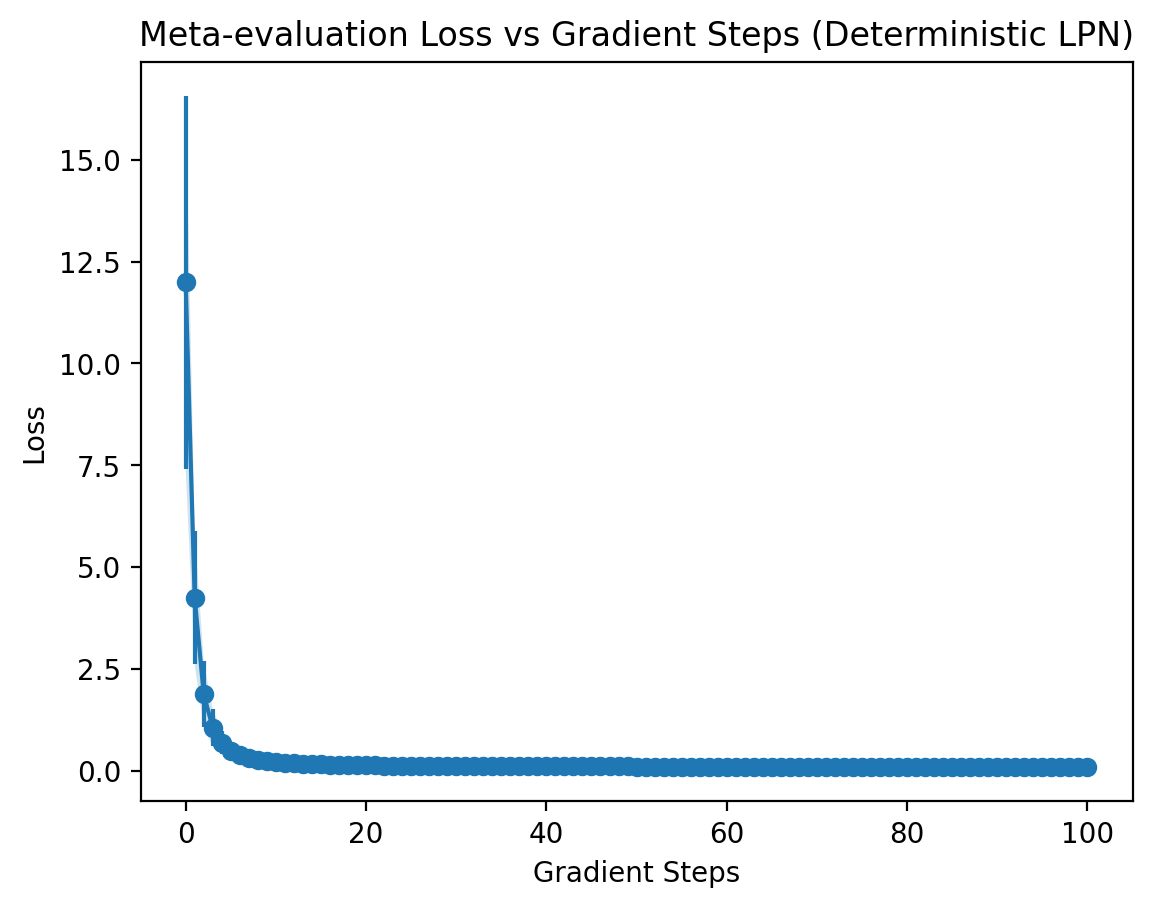

In [11]:
metaeval_losses, metaeval_mu, metaeval_ci = evaluate_deterministic_lpn(lpn, device)


torch.sum(mse).item()=62.690284729003906
torch.sum(mse).item()=14.446572303771973
torch.sum(mse).item()=5.188409805297852
torch.sum(mse).item()=2.736551523208618
torch.sum(mse).item()=1.9630247354507446
torch.sum(mse).item()=1.6065207719802856
torch.sum(mse).item()=1.3928667306900024
torch.sum(mse).item()=1.2503870725631714
torch.sum(mse).item()=1.149469017982483
torch.sum(mse).item()=1.0782006978988647
torch.sum(mse).item()=1.0255541801452637
torch.sum(mse).item()=0.9863542914390564
torch.sum(mse).item()=0.956646203994751
torch.sum(mse).item()=0.9336909055709839
torch.sum(mse).item()=0.9160748720169067
torch.sum(mse).item()=0.9023703336715698
torch.sum(mse).item()=0.8915377259254456
torch.sum(mse).item()=0.8830605745315552
torch.sum(mse).item()=0.8763384819030762
torch.sum(mse).item()=0.870639979839325
torch.sum(mse).item()=0.8656437993049622
torch.sum(mse).item()=0.8612431883811951
torch.sum(mse).item()=0.8572882413864136
torch.sum(mse).item()=0.8536637425422668
torch.sum(mse).item()

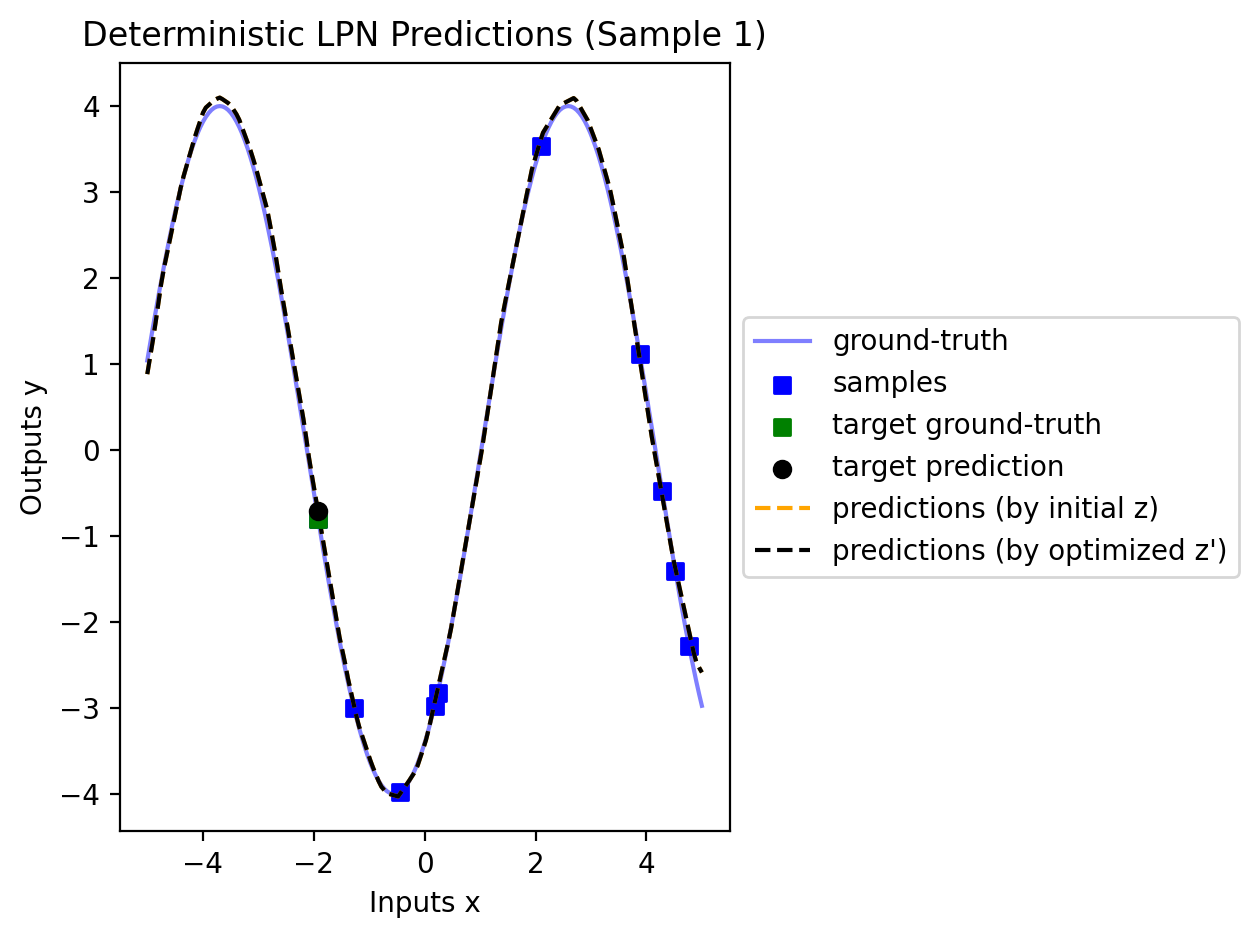

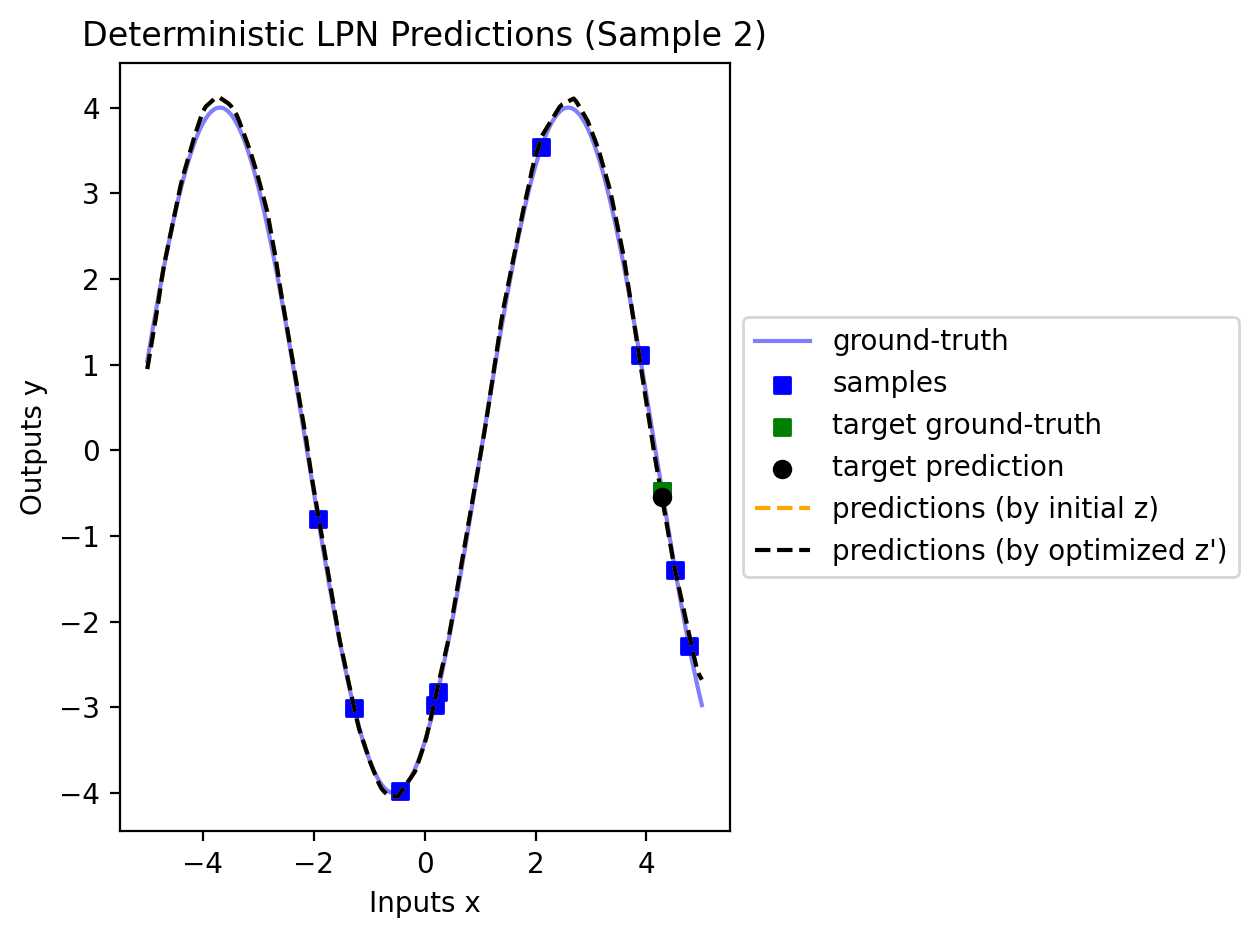

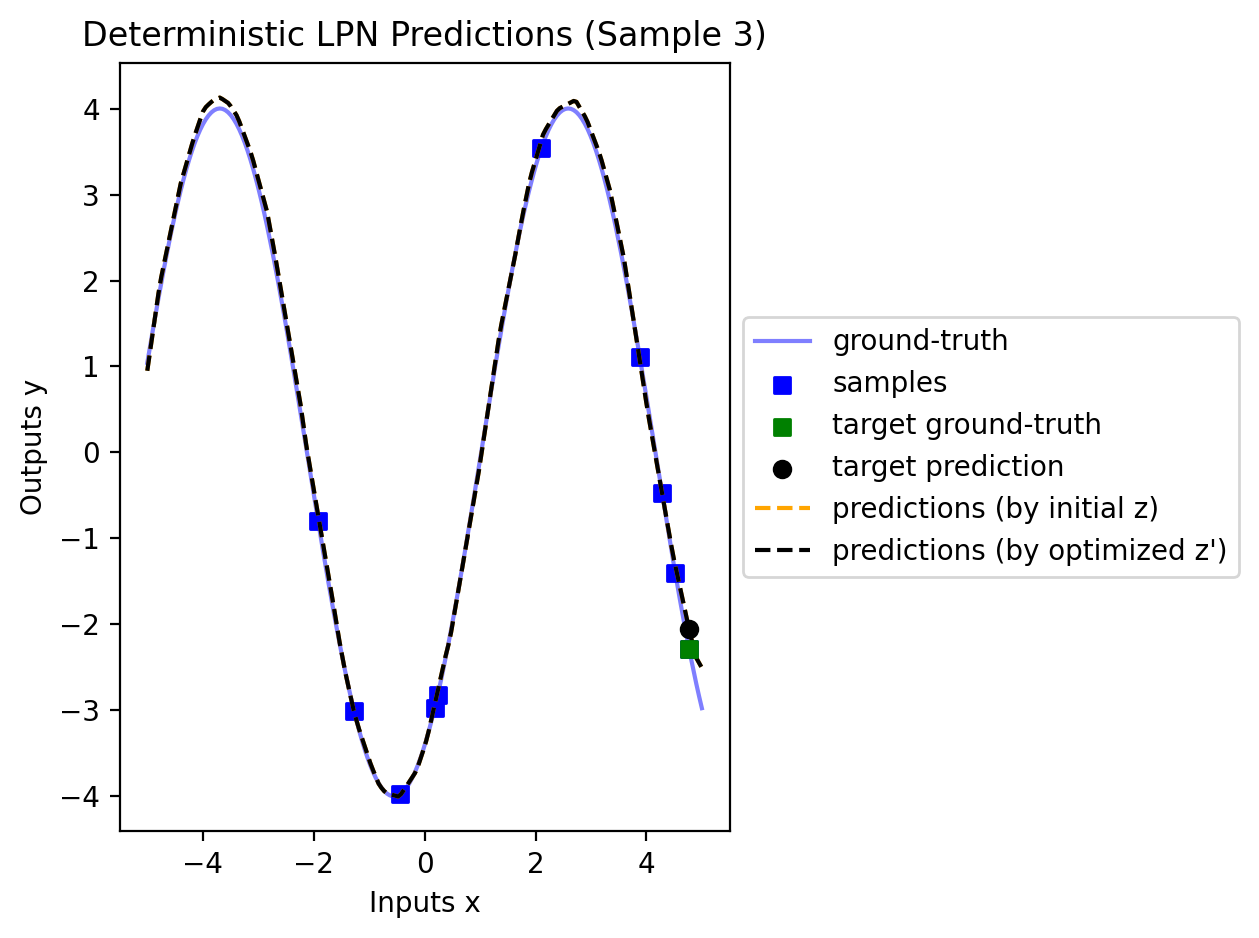

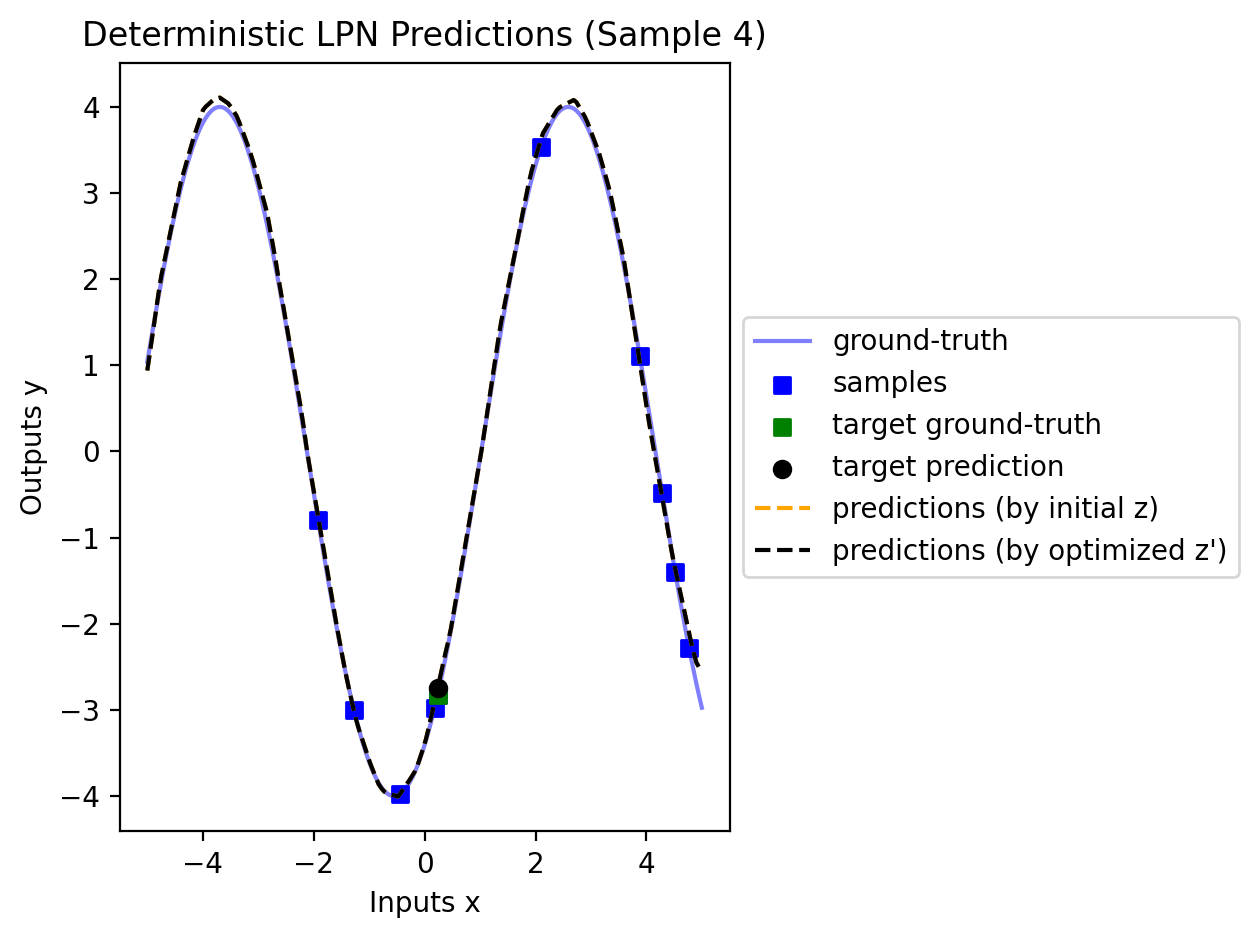

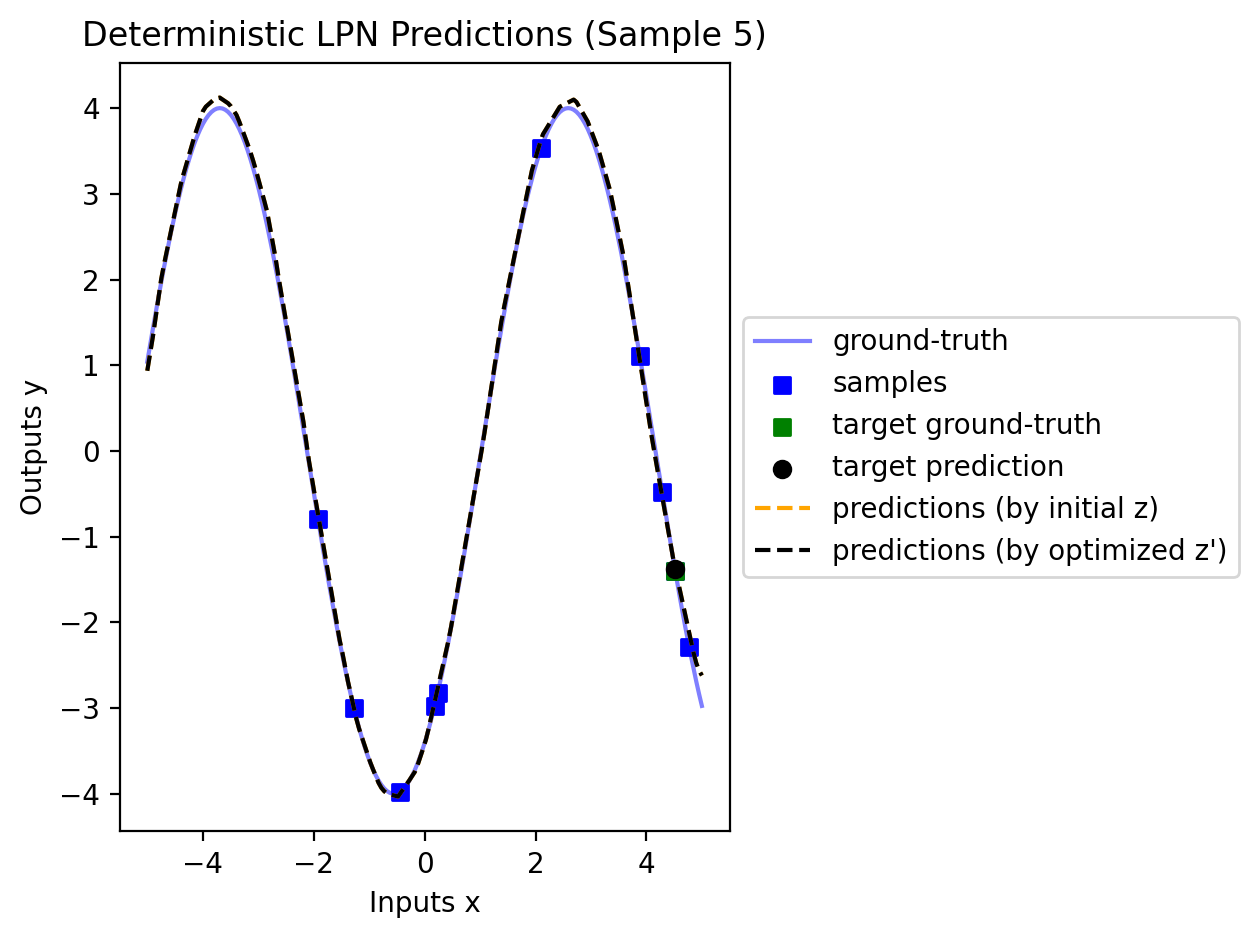

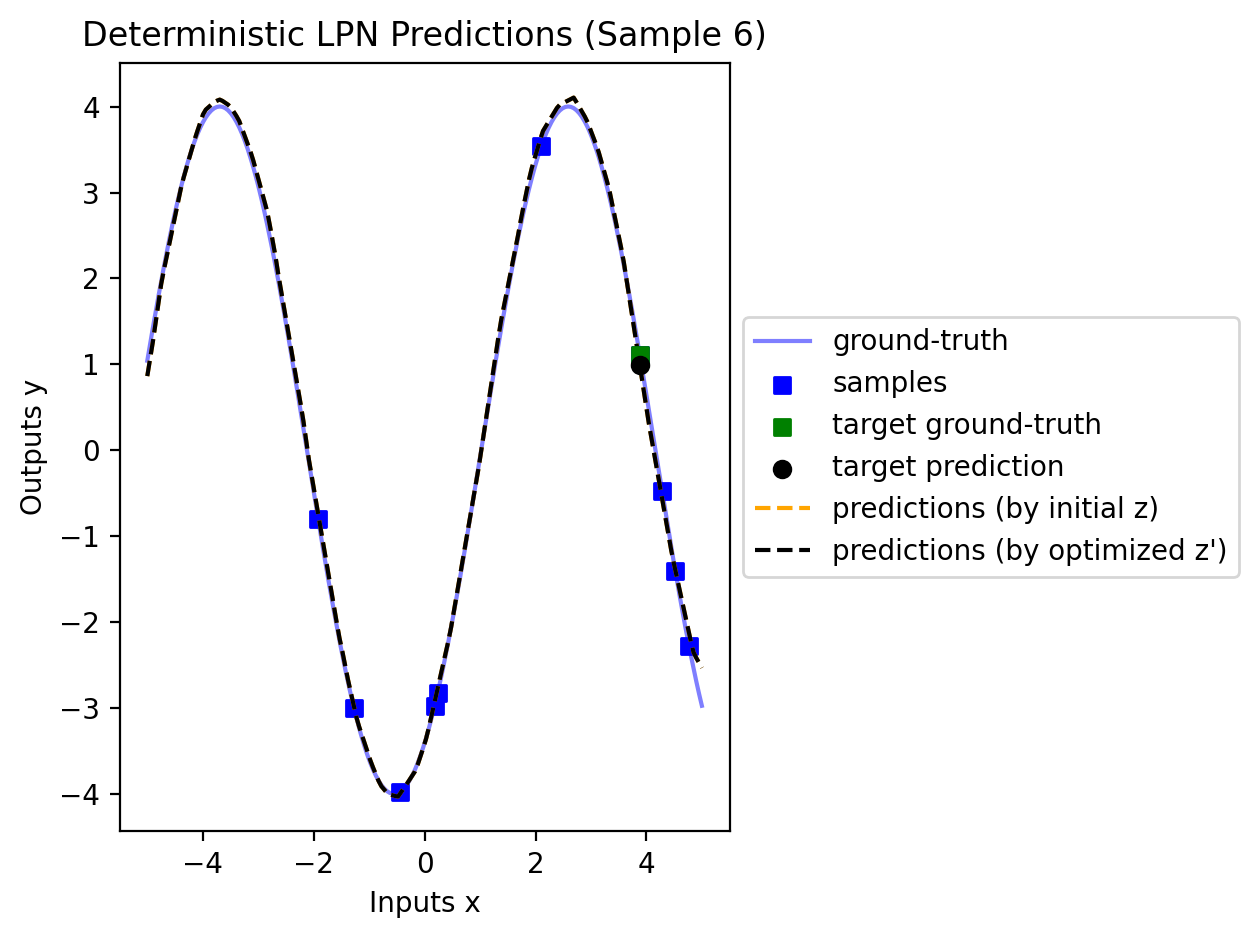

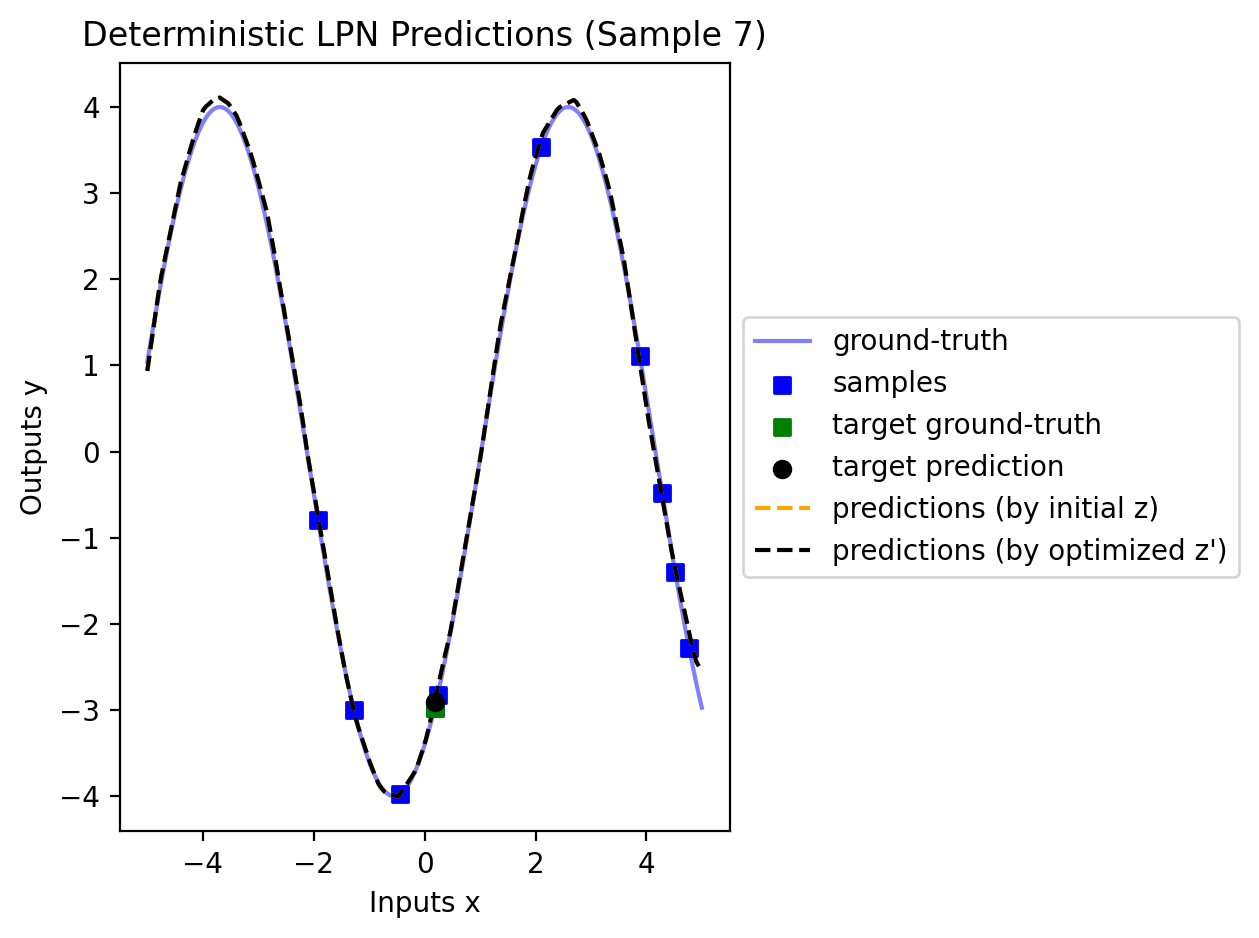

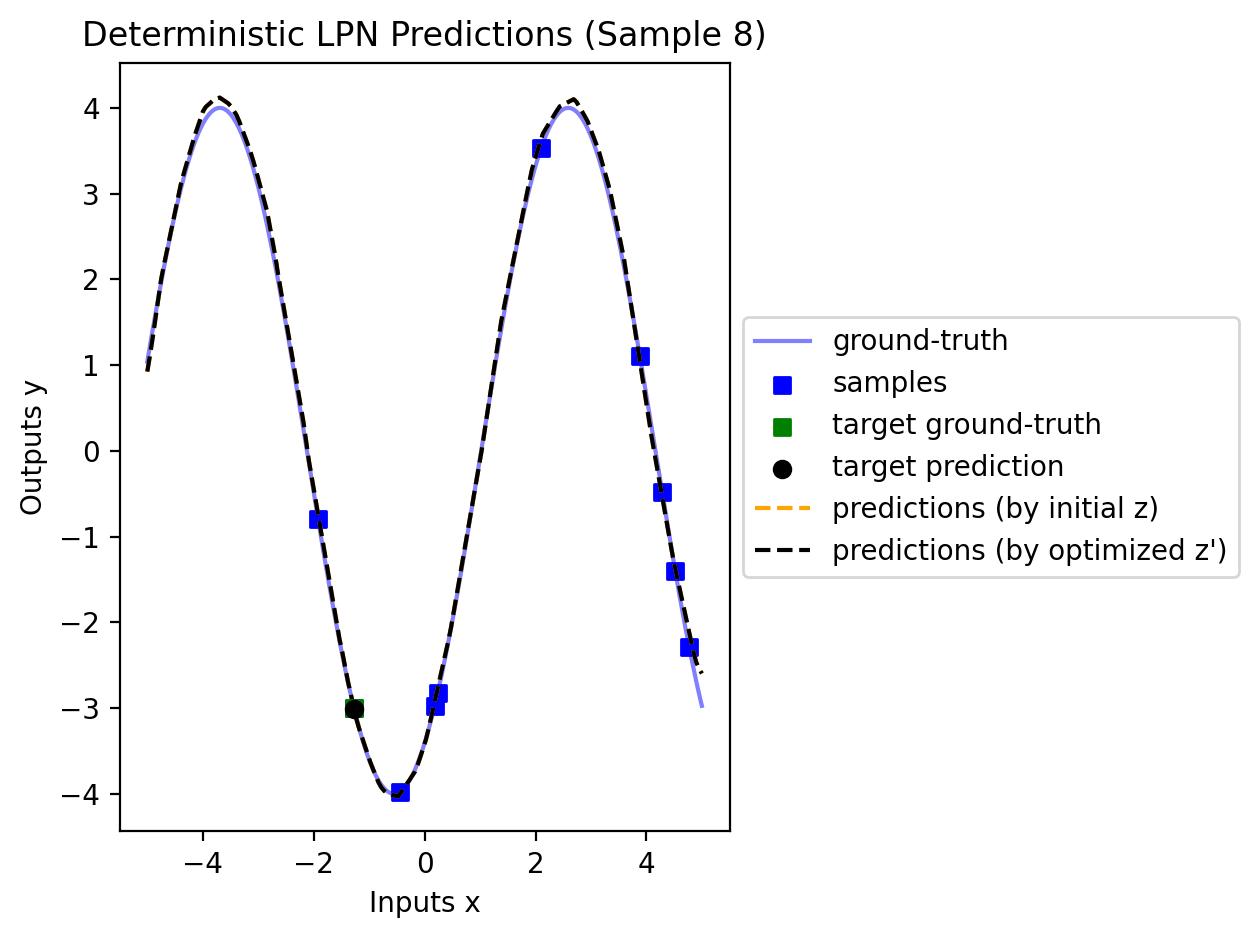

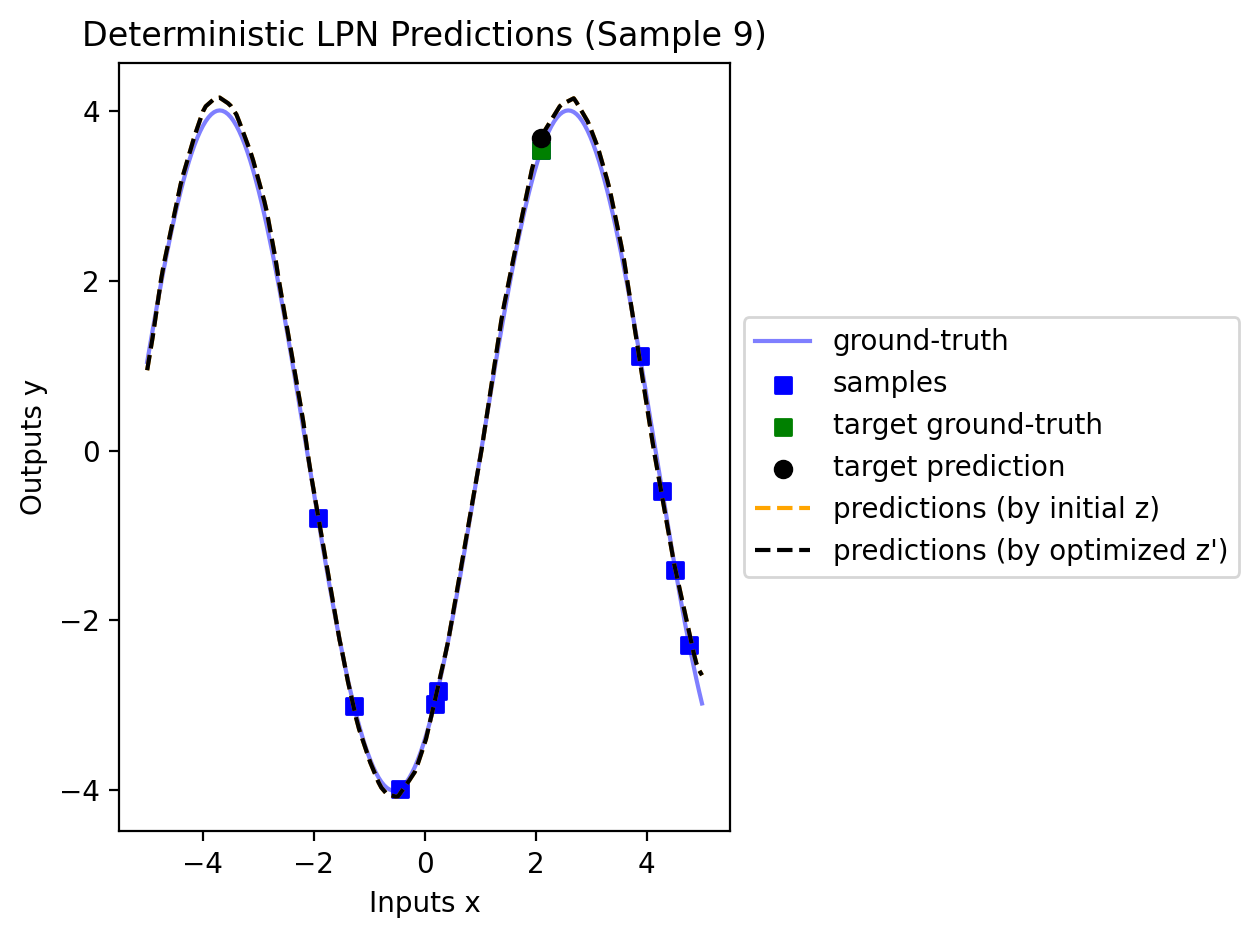

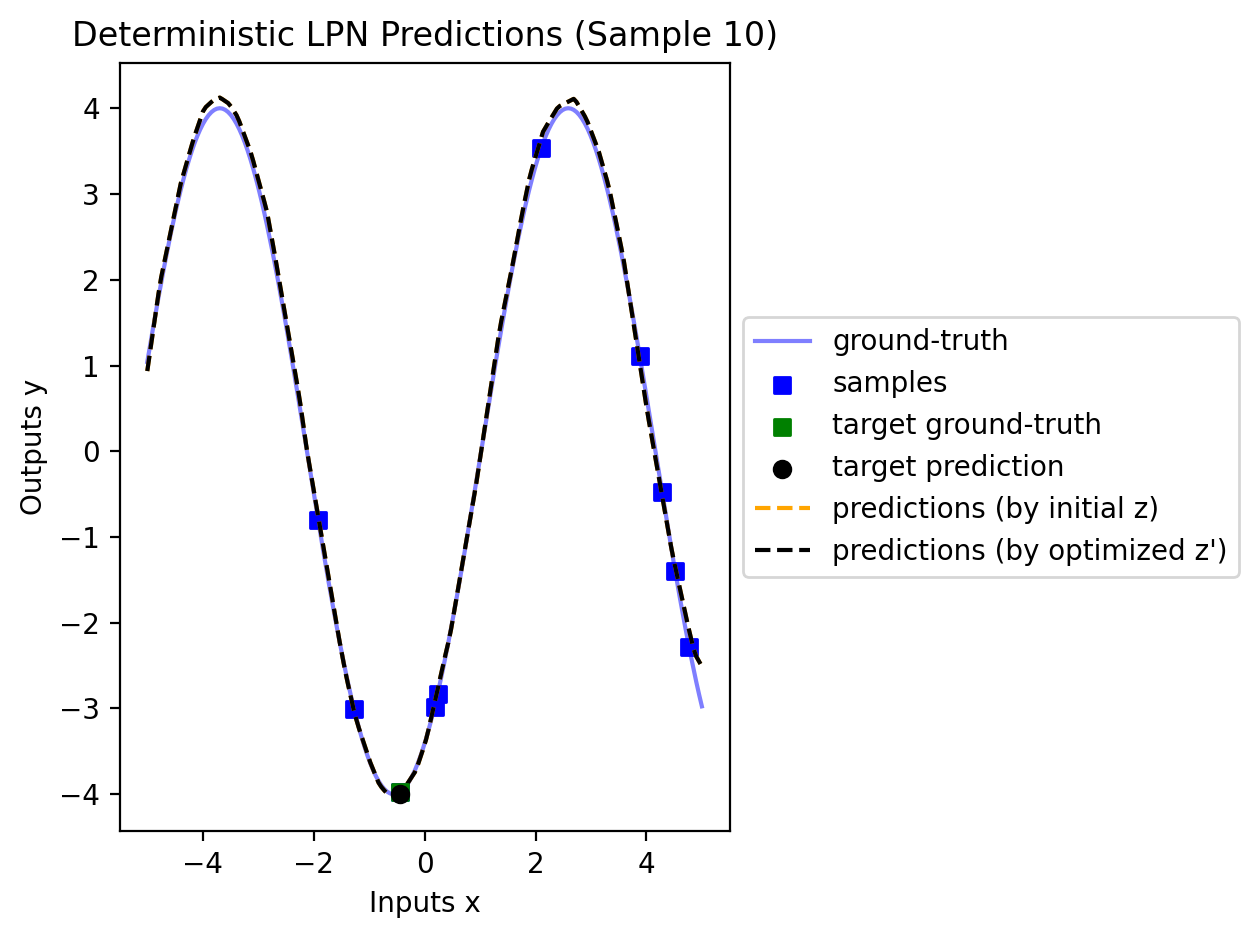

In [22]:
visualize_deterministic_lpn(lpn, device)